In [ ]:
!pip -q install ultralytics opencv-python pyyaml

import os, sys, glob, zipfile, shutil, yaml, math
import numpy as np
import cv2
import torch
from ultralytics import YOLO
from google.colab import files

print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch: 2.8.0+cu126 | CUDA available: True


In [ ]:

print("📤 Please select your dataset .zip …")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one ZIP file."
zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)


DATASET_DIR = "/content/dataset"
if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)


TMP_DIR = "/content/_unz_tmp"
if os.path.exists(TMP_DIR):
    shutil.rmtree(TMP_DIR)
os.makedirs(TMP_DIR, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall(TMP_DIR)


entries = [os.path.join(TMP_DIR, e) for e in os.listdir(TMP_DIR)]
top_dirs = [e for e in entries if os.path.isdir(e)]
src = top_dirs[0] if (len(top_dirs) == 1 and len(entries) == 1) else TMP_DIR

shutil.copytree(src, DATASET_DIR)
shutil.rmtree(TMP_DIR)
print(" Unzipped to:", DATASET_DIR)


📤 Please select your dataset .zip …


Saving Fingerprint Minutiae.v5-augmented_v5.yolov11.zip to Fingerprint Minutiae.v5-augmented_v5.yolov11.zip
Uploaded: Fingerprint Minutiae.v5-augmented_v5.yolov11.zip
✅ Unzipped to: /content/dataset


In [ ]:

DATA_YAML = None
for candidate in [
    os.path.join(DATASET_DIR, "data.yaml"),
    os.path.join(DATASET_DIR, "dataset.yaml"),
]:
    if os.path.exists(candidate):
        DATA_YAML = candidate
        break

if DATA_YAML is None:
    hits = glob.glob(os.path.join(DATASET_DIR, "**", "data.yaml"), recursive=True)
    assert hits, "data.yaml not found anywhere in the dataset."
    DATA_YAML = hits[0]

with open(DATA_YAML, "r") as f:
    data_cfg = yaml.safe_load(f)


train_images = os.path.join(DATASET_DIR, "train", "images")
valid_images = os.path.join(DATASET_DIR, "valid", "images")
val_images   = os.path.join(DATASET_DIR, "val",   "images")
test_images  = os.path.join(DATASET_DIR, "test",  "images")

if os.path.isdir(valid_images):
    data_cfg["train"] = os.path.abspath(train_images)
    data_cfg["val"]   = os.path.abspath(valid_images)
elif os.path.isdir(val_images):
    data_cfg["train"] = os.path.abspath(train_images)
    data_cfg["val"]   = os.path.abspath(val_images)
else:

    for k in ("train", "val", "valid"):
        if k in data_cfg and isinstance(data_cfg[k], str) and not data_cfg[k].startswith("/"):
            data_cfg[k] = os.path.abspath(os.path.join(DATASET_DIR, data_cfg[k]))

if os.path.isdir(test_images):
    data_cfg["test"] = os.path.abspath(test_images)


if "names" in data_cfg and isinstance(data_cfg["names"], (list, tuple)):
    data_cfg["nc"] = len(data_cfg["names"])

with open(DATA_YAML, "w") as f:
    yaml.safe_dump(data_cfg, f, sort_keys=False)

print("📝 Patched", DATA_YAML)
print(yaml.safe_dump(data_cfg, sort_keys=False))


📝 Patched /content/dataset/data.yaml
train: /content/dataset/train/images
val: /content/dataset/valid/images
test: ../test/images
nc: 3
names:
- burification
- center
- ending
roboflow:
  workspace: khubab-ahmad
  project: fingerprint-minutiae
  version: 5
  license: CC BY 4.0
  url: https://universe.roboflow.com/khubab-ahmad/fingerprint-minutiae/dataset/5



In [ ]:
def count_imgs(p):
    return len(glob.glob(os.path.join(p, "*.jpg"))) + len(glob.glob(os.path.join(p, "*.png")))

ti = count_imgs(os.path.join(DATASET_DIR, "train", "images"))
vi = count_imgs(os.path.join(DATASET_DIR, "valid", "images")) + count_imgs(os.path.join(DATASET_DIR, "val", "images"))
print(f"📊 Train images: {ti}")
print(f"📊 Valid/Val images: {vi}")

for p in [
    os.path.join(DATASET_DIR, "train", "images"),
    os.path.join(DATASET_DIR, "train", "labels"),
    os.path.join(DATASET_DIR, "valid", "images"),
    os.path.join(DATASET_DIR, "valid", "labels"),
]:
    if os.path.isdir(p):
        some = sorted(glob.glob(os.path.join(p, "*.*")))[:5]
        print("", p, "->", len(some), "sample(s):", [os.path.basename(s) for s in some])


📊 Train images: 480
📊 Valid/Val images: 40
📂 /content/dataset/train/images -> 5 sample(s): ['101_1_jpg.rf.01c4b3021b799bc9268d94596fb89db9.jpg', '101_1_jpg.rf.6ba5ecf368ecb1837e920d6b82a543da.jpg', '101_1_jpg.rf.88793b9d9d9fa94a967c3441031c75ff.jpg', '101_1_jpg.rf.97af06b6b52429b57a0db16b08b0687d.jpg', '101_1_jpg.rf.a2c64aeb76e0950cee16d2a25e975e1c.jpg']
📂 /content/dataset/train/labels -> 5 sample(s): ['101_1_jpg.rf.01c4b3021b799bc9268d94596fb89db9.txt', '101_1_jpg.rf.6ba5ecf368ecb1837e920d6b82a543da.txt', '101_1_jpg.rf.88793b9d9d9fa94a967c3441031c75ff.txt', '101_1_jpg.rf.97af06b6b52429b57a0db16b08b0687d.txt', '101_1_jpg.rf.a2c64aeb76e0950cee16d2a25e975e1c.txt']
📂 /content/dataset/valid/images -> 5 sample(s): ['102_5_jpg.rf.a518b0ec8bc186c51dc8380ff35ae26a.jpg', '102_7_jpg.rf.aa285bb590d48b3c62035cf0f1d80228.jpg', '102_8_jpg.rf.540c75ab3ba9b8f933b4f60ece24fb5c.jpg', '103_1_jpg.rf.e491c2b315cef4ff0fed14f73a0f01c0.jpg', '103_2_jpg.rf.4d5bb2ded0743a5c9926bb00a8c53dc7.jpg']
📂 /content/data

In [ ]:
HYP_YAML = "/content/hyp_minutiae.yaml"
hyp = dict(
    lr0=0.002, lrf=0.2, momentum=0.937, weight_decay=0.0005,
    warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
    box=7.5, cls=1.0, dfl=1.5, fl_gamma=1.5,  # focal-like
    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,
    degrees=0.0, translate=0.05, scale=0.2, shear=0.0,
    perspective=0.0, mosaic=0.5, mixup=0.0, copy_paste=0.0
)
with open(HYP_YAML, "w") as f:
    yaml.safe_dump(hyp, f, sort_keys=False)
print(open(HYP_YAML).read())


lr0: 0.002
lrf: 0.2
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 7.5
cls: 1.0
dfl: 1.5
fl_gamma: 1.5
hsv_h: 0.0
hsv_s: 0.2
hsv_v: 0.2
degrees: 0.0
translate: 0.05
scale: 0.2
shear: 0.0
perspective: 0.0
mosaic: 0.5
mixup: 0.0
copy_paste: 0.0



In [ ]:
from ultralytics import YOLO
import torch

device = 0 if torch.cuda.is_available() else "cpu"
MODEL_NAME = "yolo11x.pt"
IMGSZ = 512
EPOCHS = 200
BATCH  = 16 if torch.cuda.is_available() else 8

model = YOLO(MODEL_NAME)

results = model.train(
    data=DATA_YAML,
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    workers=8 if torch.cuda.is_available() else 0,
    device=device,
    optimizer="adamw",
    cos_lr=True,
    patience=50,
    amp=True,
    cache=True,


    lr0=0.002,
    lrf=0.2,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,


    box=7.5, cls=1.0, dfl=1.5,


    hsv_h=0.0, hsv_s=0.2, hsv_v=0.2,
    degrees=0.0, translate=0.05, scale=0.2, shear=0.0,
    perspective=0.0, mosaic=0.5, mixup=0.0, copy_paste=0.0
)


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.2, hsv_v=0.2, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.2, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=adamw, overlap_mask=True, patience=50, perspective=0.0, plots=True, pose=12.0, pre

In [ ]:
val_res = model.val(data=DATA_YAML, imgsz=IMGSZ, device=device)
print(val_res)


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 531.7±358.2 MB/s, size: 18.3 KB)
val: Scanning /content/dataset/valid/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 40/40 48.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.0s/it 3.1s
                   all         40        467      0.581       0.72       0.66      0.338
          burification         40        213      0.576      0.559      0.581      0.307
                center         40         40      0.683      0.916      0.812      0.412
                ending         40        214      0.483      0.687      0.586      0.297
Speed: 5.3ms preprocess, 51.9ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.u

In [ ]:

valid_dir = os.path.join(DATASET_DIR, "valid", "images")
fallback_dir = os.path.join(DATASET_DIR, "val", "images")
samples = glob.glob(os.path.join(valid_dir, "*.*")) or glob.glob(os.path.join(fallback_dir, "*.*"))
assert samples, "No images found in valid/val images dir."

sample = samples[0]
print("Predicting on:", sample)

pred = model.predict(
    source=sample,
    imgsz=IMGSZ,
    conf=0.15,
    iou=0.6,
    device=device,
    save=True, augment=True, agnostic_nms=True, max_det=500
)
pred


Predicting on: /content/dataset/valid/images/109_8_jpg.rf.7385eed01014ccccaa04e1c262c548b4.jpg

image 1/1 /content/dataset/valid/images/109_8_jpg.rf.7385eed01014ccccaa04e1c262c548b4.jpg: 512x512 14 burifications, 2 centers, 18 endings, 256.6ms
Speed: 3.0ms preprocess, 256.6ms inference, 5.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'burification', 1: 'center', 2: 'ending'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],


In [ ]:
from ultralytics import YOLO
import glob, os, torch

device = 0 if torch.cuda.is_available() else "cpu"


best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


valid_dir = "/content/dataset/valid/images"  # or /content/dataset/val/images
samples = sorted(glob.glob(os.path.join(valid_dir, "*.*")))[:8]
print("Using samples:", [os.path.basename(s) for s in samples])


pred = model.predict(
    source=samples, imgsz=512,
    conf=0.15, iou=0.6,
    device=device, save=True, augment=True, agnostic_nms=True, max_det=500
)


Using samples: ['102_5_jpg.rf.a518b0ec8bc186c51dc8380ff35ae26a.jpg', '102_7_jpg.rf.aa285bb590d48b3c62035cf0f1d80228.jpg', '102_8_jpg.rf.540c75ab3ba9b8f933b4f60ece24fb5c.jpg', '103_1_jpg.rf.e491c2b315cef4ff0fed14f73a0f01c0.jpg', '103_2_jpg.rf.4d5bb2ded0743a5c9926bb00a8c53dc7.jpg', '103_3_jpg.rf.ab75ed89935ae4ed2dc326f8c2130985.jpg', '103_5_jpg.rf.0dcb87bbec401df6ad75a9ff083034a2.jpg', '103_6_jpg.rf.c615b42c53615aa82bfc0f657ee7cf88.jpg']

0: 512x512 24 burifications, 3 centers, 14 endings, 83.4ms
1: 512x512 4 burifications, 4 centers, 9 endings, 83.4ms
2: 512x512 5 burifications, 3 centers, 7 endings, 83.4ms
3: 512x512 6 burifications, 3 centers, 11 endings, 83.4ms
4: 512x512 4 burifications, 3 centers, 9 endings, 83.4ms
5: 512x512 6 burifications, 5 centers, 8 endings, 83.4ms
6: 512x512 11 burifications, 3 centers, 8 endings, 83.4ms
7: 512x512 9 burifications, 2 centers, 9 endings, 83.4ms
Speed: 1.3ms preprocess, 83.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Re

In [ ]:
from ultralytics import YOLO
import glob, os, torch

device = 0 if torch.cuda.is_available() else "cpu"


best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


valid_dir = "/content/dataset/valid/images"  # or /content/dataset/val/images
samples = sorted(glob.glob(os.path.join(valid_dir, "*.*")))[:8]
print("Using samples:", [os.path.basename(s) for s in samples])


pred = model.predict(
    source=samples, imgsz=512,
    conf=0.15, iou=0.6,
    device=device, save=True, augment=True, agnostic_nms=True, max_det=500
)


Using samples: ['102_5_jpg.rf.a518b0ec8bc186c51dc8380ff35ae26a.jpg', '102_7_jpg.rf.aa285bb590d48b3c62035cf0f1d80228.jpg', '102_8_jpg.rf.540c75ab3ba9b8f933b4f60ece24fb5c.jpg', '103_1_jpg.rf.e491c2b315cef4ff0fed14f73a0f01c0.jpg', '103_2_jpg.rf.4d5bb2ded0743a5c9926bb00a8c53dc7.jpg', '103_3_jpg.rf.ab75ed89935ae4ed2dc326f8c2130985.jpg', '103_5_jpg.rf.0dcb87bbec401df6ad75a9ff083034a2.jpg', '103_6_jpg.rf.c615b42c53615aa82bfc0f657ee7cf88.jpg']

0: 512x512 24 burifications, 3 centers, 14 endings, 83.0ms
1: 512x512 4 burifications, 4 centers, 9 endings, 83.0ms
2: 512x512 5 burifications, 3 centers, 7 endings, 83.0ms
3: 512x512 6 burifications, 3 centers, 11 endings, 83.0ms
4: 512x512 4 burifications, 3 centers, 9 endings, 83.0ms
5: 512x512 6 burifications, 5 centers, 8 endings, 83.0ms
6: 512x512 11 burifications, 3 centers, 8 endings, 83.0ms
7: 512x512 9 burifications, 2 centers, 9 endings, 83.0ms
Speed: 1.4ms preprocess, 83.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Re

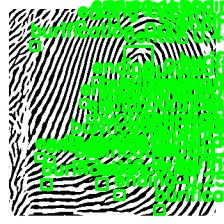

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)

#
names = model.names

def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1,y1,x2,y2), p, c in zip(boxes_xyxy, confs, clses):
        x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), 2)
        label = f"{names[int(c)]} {float(p):.2f}" if int(c) in names else f"{int(c)} {float(p):.2f}"
        cv2.putText(out, label, (x1, max(10,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
    return out

img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]  # choose one
img = cv2.imread(img_path)

res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]
boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))

vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)


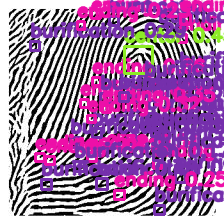

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names


def get_color_for_class(cls_id):
    np.random.seed(cls_id)
    color = np.random.randint(0, 255, 3)
    return int(color[0]), int(color[1]), int(color[2])


def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), p, c in zip(boxes_xyxy, confs, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)


        color = get_color_for_class(cls_id)

        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

        label = f"{names[cls_id]} {float(p):.2f}" if cls_id in names else f"{cls_id} {float(p):.2f}"

        cv2.putText(out, label, (x1, max(10, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out


img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)

# ------------------------------------------
# Inference
# ------------------------------------------
res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]
boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))


vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)


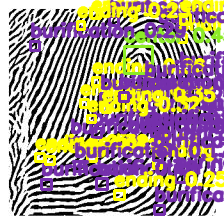

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names


SPECIAL_COLORS = {
    "ending": (0, 255, 255)
}


def get_color_for_class(cls_id):
    cls_name = names[int(cls_id)]


    if cls_name in SPECIAL_COLORS:
        return SPECIAL_COLORS[cls_name]


    np.random.seed(cls_id)
    color = np.random.randint(0, 255, 3)
    return int(color[0]), int(color[1]), int(color[2])


def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), p, c in zip(boxes_xyxy, confs, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)
        cls_name = names[cls_id]


        color = get_color_for_class(cls_id)


        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)


        label = f"{cls_name} {float(p):.2f}"
        cv2.putText(out, label, (x1, max(10, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    return out



img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)

res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]
boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))

vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)


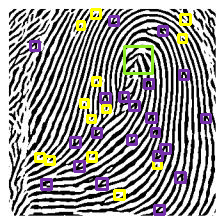

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names

SPECIAL_COLORS = {
    "ending": (0, 255, 255)
}


def get_color_for_class(cls_id):
    cls_name = names[int(cls_id)]


    if cls_name in SPECIAL_COLORS:
        return SPECIAL_COLORS[cls_name]


    np.random.seed(cls_id)
    color = np.random.randint(0, 255, 3)
    return int(color[0]), int(color[1]), int(color[2])


def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), p, c in zip(boxes_xyxy, confs, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)

        color = get_color_for_class(cls_id)


        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

    return out



img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)


res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]

boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))

# ------------------------------------------
# Visualize
# ------------------------------------------
vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)



===== ENDING VALUES =====
1. [80.23571014404297, 99.70108795166016, 88.41001892089844, 107.32980346679688, 0.690500795841217]
2. [91.73047637939453, 9.959478378295898, 100.23441314697266, 18.026647567749023, 0.6638234853744507]
3. [92.13497161865234, 77.30889892578125, 100.45745849609375, 85.61652374267578, 0.6596499681472778]
4. [178.34027099609375, 34.29697799682617, 186.7612762451172, 42.1791877746582, 0.5986692309379578]
5. [153.0477752685547, 160.63998413085938, 161.38417053222656, 168.8839111328125, 0.5319602489471436]
6. [87.81100463867188, 152.92063903808594, 96.30139923095703, 161.00218200683594, 0.5076250433921814]
7. [45.46695327758789, 156.5346221923828, 54.27616500854492, 164.83885192871094, 0.4129047393798828]
8. [102.3305435180664, 105.35360717773438, 110.42221069335938, 112.91946411132812, 0.3455737829208374]
9. [35.60622024536133, 153.21746826171875, 44.22323989868164, 161.5028533935547, 0.3224197328090668]
10. [87.6819076538086, 115.31266784667969, 95.74441528320312,

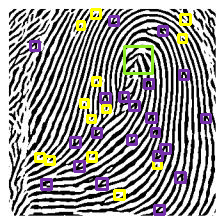

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names


SPECIAL_COLORS = {
    "ending": (0, 255, 255)
}


def get_color_for_class(cls_id):
    cls_name = names[int(cls_id)]
    if cls_name in SPECIAL_COLORS:
        return SPECIAL_COLORS[cls_name]
    np.random.seed(cls_id)
    c = np.random.randint(0, 255, 3)
    return int(c[0]), int(c[1]), int(c[2])


def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), p, c in zip(boxes_xyxy, confs, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)
        color = get_color_for_class(cls_id)


        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

    return out



img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)


res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]

boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))


ending_boxes = []
ending_class_id = None


for cid, cname in names.items():
    if cname.lower() == "ending":
        ending_class_id = cid
        break

print("\n===== ENDING VALUES =====")

if ending_class_id is None:
    print("Class 'ending' not found in model classes.")
else:
    for b, conf, c in zip(boxes, confs, clses):
        if int(c) == ending_class_id:
            x1, y1, x2, y2 = b
            ending_boxes.append([float(x1), float(y1), float(x2), float(y2), float(conf)])

    if len(ending_boxes) == 0:
        print("No ending points detected.")
    else:
        for i, det in enumerate(ending_boxes):
            print(f"{i+1}. {det}")

print("====================================\n")



vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)


Model classes: {0: 'burification', 1: 'center', 2: 'ending'}
Using image: /content/dataset/valid/images/102_5_jpg.rf.a518b0ec8bc186c51dc8380ff35ae26a.jpg

Detected class IDs in this image: [0, 1, 2]
All model class IDs: [0, 1, 2]
Classes NOT detected in this image: []
Detected class names: ['burification', 'center', 'ending']


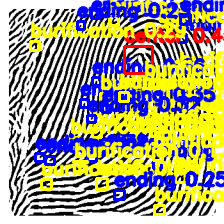

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch, yaml
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names
print("Model classes:", names)


CLASS_COLORS = {
    0: (0, 255, 255),
    1: (0, 0, 255),
    2: (255, 0, 0),
    3: (0, 255, 0),
}


def get_color_for_class(cls_id):
    if cls_id in CLASS_COLORS:
        return CLASS_COLORS[cls_id]
    np.random.seed(cls_id)
    color = np.random.randint(0, 255, 3)
    return int(color[0]), int(color[1]), int(color[2])


def draw_boxes(img_bgr, boxes_xyxy, confs, clses, names):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), p, c in zip(boxes_xyxy, confs, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)


        color = get_color_for_class(cls_id)

        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)


        cls_name = names.get(cls_id, str(cls_id))
        label = f"{cls_name} {float(p):.2f}"

        cv2.putText(out, label, (x1, max(10, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return out



img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
print("Using image:", img_path)
img = cv2.imread(img_path)


res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]
boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0,4))
confs = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.empty((0,))
clses = res.boxes.cls.cpu().numpy()  if res.boxes is not None else np.empty((0,))


if len(clses) > 0:
    detected_class_ids = sorted(set(int(c) for c in clses))
else:
    detected_class_ids = []

all_class_ids = sorted(list(names.keys()))
missing_class_ids = sorted(set(all_class_ids) - set(detected_class_ids))

print("\nDetected class IDs in this image:", detected_class_ids)
print("All model class IDs:", all_class_ids)
print("Classes NOT detected in this image:", missing_class_ids)

print("Detected class names:",
      [names[cid] for cid in detected_class_ids] if detected_class_ids else "None")


vis = draw_boxes(img, boxes, confs, clses, names)
cv2_imshow(vis)


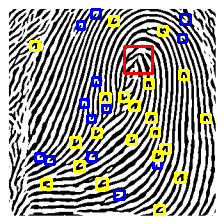

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)


names = model.names


CLASS_COLORS = {
    0: (0, 255, 255),
    1: (0, 0, 255),
    2: (255, 0, 0),
    3: (0, 255, 0),
}


def get_color_for_class(cls_id):
    if cls_id in CLASS_COLORS:
        return CLASS_COLORS[cls_id]
    np.random.seed(cls_id)
    c = np.random.randint(0, 255, 3)
    return int(c[0]), int(c[1]), int(c[2])


def draw_boxes(img_bgr, boxes_xyxy, clses):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), c in zip(boxes_xyxy, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cls_id = int(c)
        color = get_color_for_class(cls_id)

        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)

    return out


img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)


res = model.predict(img, imgsz=512, conf=0.15, iou=0.6, device=device, verbose=False)[0]

boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0, 4))
clses = res.boxes.cls.cpu().numpy() if res.boxes is not None else np.empty((0,))


vis = draw_boxes(img, boxes, clses)
cv2_imshow(vis)


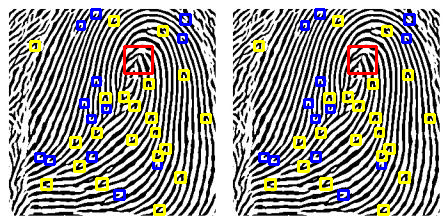

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)

names = model.names

CLASS_COLORS = {
    0: (0, 255, 255),
    1: (0, 0, 255),
    2: (255, 0, 0),
    3: (0, 255, 0),
}

def get_color_for_class(cls_id):
    if cls_id in CLASS_COLORS:
        return CLASS_COLORS[cls_id]
    np.random.seed(cls_id)
    c = np.random.randint(0, 255, 3)
    return int(c[0]), int(c[1]), int(c[2])

def draw_boxes(img_bgr, boxes_xyxy, clses):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), c in zip(boxes_xyxy, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        color = get_color_for_class(int(c))
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
    return out



img_path = sorted(glob.glob("/content/dataset/valid/images/*.*"))[0]
img = cv2.imread(img_path)


res = model.predict(img, imgsz=512, conf=0.15, iou=0.6,
                    device=device, verbose=False)[0]

boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0, 4))
clses = res.boxes.cls.cpu().numpy() if res.boxes is not None else np.empty((0,))


original_with_boxes = draw_boxes(img, boxes, clses)
predicted_with_boxes = draw_boxes(img, boxes, clses)


combined = np.hstack([original_with_boxes, predicted_with_boxes])


cv2_imshow(combined)



===== SAMPLE 1 =====
Image: 102_5_jpg.rf.a518b0ec8bc186c51dc8380ff35ae26a.jpg
Detections: 35


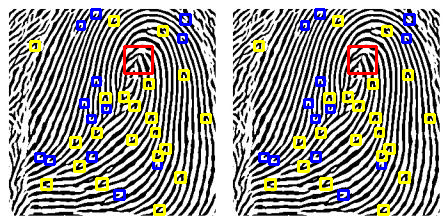


===== SAMPLE 2 =====
Image: 102_7_jpg.rf.aa285bb590d48b3c62035cf0f1d80228.jpg
Detections: 12


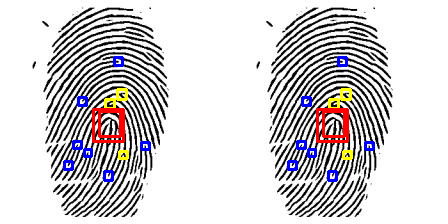


===== SAMPLE 3 =====
Image: 102_8_jpg.rf.540c75ab3ba9b8f933b4f60ece24fb5c.jpg
Detections: 13


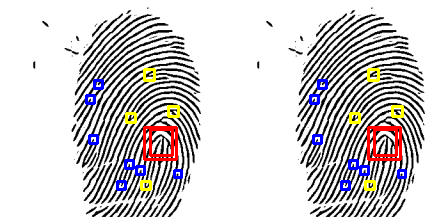


===== SAMPLE 4 =====
Image: 103_1_jpg.rf.e491c2b315cef4ff0fed14f73a0f01c0.jpg
Detections: 17


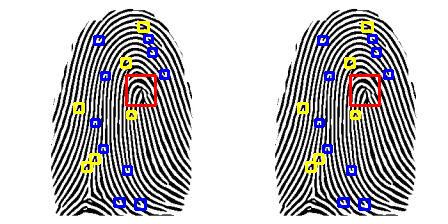


===== SAMPLE 5 =====
Image: 103_2_jpg.rf.4d5bb2ded0743a5c9926bb00a8c53dc7.jpg
Detections: 14


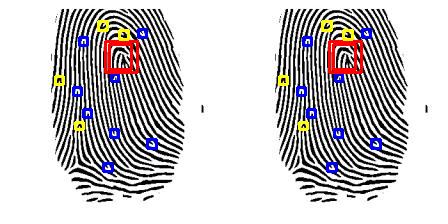

In [ ]:
from ultralytics import YOLO
import cv2, numpy as np, glob, os, torch
from google.colab.patches import cv2_imshow

device = 0 if torch.cuda.is_available() else "cpu"
best = sorted(glob.glob("runs/detect/train*/weights/best.pt"))[-1]
model = YOLO(best)

names = model.names

# Fixed colors
CLASS_COLORS = {
    0: (0, 255, 255),
    1: (0, 0, 255),
    2: (255, 0, 0),
    3: (0, 255, 0),
}

def get_color_for_class(cls_id):
    if cls_id in CLASS_COLORS:
        return CLASS_COLORS[cls_id]
    np.random.seed(cls_id)
    c = np.random.randint(0, 255, 3)
    return int(c[0]), int(c[1]), int(c[2])

def draw_boxes(img_bgr, boxes_xyxy, clses):
    out = img_bgr.copy()
    for (x1, y1, x2, y2), c in zip(boxes_xyxy, clses):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        color = get_color_for_class(int(c))
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
    return out



img_paths = sorted(glob.glob("/content/dataset/valid/images/*.*"))[:5]

for idx, img_path in enumerate(img_paths, start=1):

    img = cv2.imread(img_path)

    # Prediction
    res = model.predict(img, imgsz=512, conf=0.15, iou=0.6,
                        device=device, verbose=False)[0]

    boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.empty((0, 4))
    clses = res.boxes.cls.cpu().numpy() if res.boxes is not None else np.empty((0,))


    original_with_boxes = draw_boxes(img, boxes, clses)
    predicted_with_boxes = draw_boxes(img, boxes, clses)


    combined = np.hstack([original_with_boxes, predicted_with_boxes])

    print(f"\n===== SAMPLE {idx} =====")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Detections: {len(boxes)}")

    # Show result
    cv2_imshow(combined)


In [ ]:
best_model = YOLO("runs/detect/train/weights/best.pt")

val_results = best_model.val(
    data=DATA_YAML,
    split="val",
    imgsz=IMGSZ
)

print("mAP50 (Val Accuracy):", val_results.results_dict["metrics/mAP50(B)"])


Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 954.8±312.4 MB/s, size: 20.4 KB)
val: Scanning /content/dataset/valid/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 40/40 50.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.1it/s 2.6s
                   all         40        467      0.581       0.72       0.66      0.338
          burification         40        213      0.576      0.559      0.581      0.307
                center         40         40      0.683      0.916      0.812      0.412
                ending         40        214      0.483      0.687      0.586      0.297
Speed: 5.3ms preprocess, 41.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/runs/detect/val2
mAP50 (Val A